<a href="https://colab.research.google.com/github/j-physics/Mech_Interp_Exploratory/blob/main/singlelayer_FAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformer-lens

In [2]:
#import necessary libraries or packages
import torch
import transformer_lens
from transformer_lens import HookedTransformer

#check GPU is working right
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

GPU available: True
Device: NVIDIA L4


In [3]:
#load a small model (e.g., gpt2-small, pythia-70m)
model = HookedTransformer.from_pretrained("pythia-70m", device="cuda")

#check to see model is loading
text = "Hi, my name is Jessica."
tokens = model.to_tokens(text)
logits = model(tokens)
print(f"Tokens shape: {tokens.shape}")
print(f"Logits shape: {logits.shape}")


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model pythia-70m into HookedTransformer
Tokens shape: torch.Size([1, 8])
Logits shape: torch.Size([1, 8, 50304])


In [4]:
!pip install sae_lens

In [5]:
#integrate SAEs from TransformerLens
from transformer_lens import HookedTransformer
from sae_lens import SAE

#Load SAE for a specific layer(s)
sae, cfg_dict, sparsity = SAE.from_pretrained_with_cfg_and_sparsity(
    release="ctigges/pythia-70m-deduped__res-sm_processed",
    sae_id="2-res-sm",
    device="cuda"
)

In [6]:
#feature activation analysis (FAA)

#Testing some text out
text = "There is a tiger in the room"
tokens = model.to_tokens(text)

#Getting the activations at a single layer
_, cache = model.run_with_cache(tokens)
layer_acts = cache["blocks.2.hook_resid_post"]

#Run through SAE to get feature activations of singlelayer
feature_acts = sae.encode(layer_acts)

#Seeing which features fired
print(f"Shape: {feature_acts.shape}") #should be in the format [batch, seq_len, num_feat]
print(f"Non-zero features: {(feature_acts > 0).sum()}")

#Find the top activating features
top_features = feature_acts[0, -1].topk(10) #top 10 at the last token
print(f"Top features: {top_features.indices}")
print(f"Activations: {top_features.values}")

Shape: torch.Size([1, 8, 32768])
Non-zero features: 8739
Top features: tensor([27045, 32604, 16978, 17575, 23734, 19777, 14190,  6079,  7552, 20236],
       device='cuda:0')
Activations: tensor([1.5125, 1.2771, 1.2396, 1.2269, 0.8035, 0.7915, 0.7530, 0.7471, 0.7292,
        0.6755], device='cuda:0', grad_fn=<TopkBackward0>)


In [7]:
#Looking at each token position now
tokens_str = model.to_str_tokens(text)
print("Tokens:", tokens_str)

# for pos in range(len(tokens_str)):
#   top_at_pos = feature_acts[0, pos].topk(5)
#   print(f"\nToken {pos} ('{tokens_str[pos]}'):")
#   print(f" Top features: {top_at_pos.indices.tolist()}")
#   #print(f" Activations: {top_at_pos.values.tolist()}")

#nice format to show what sentence I am analyzing
print("=" * 60)
print(f"Analyzing: '{text}'")
print("=" * 60)

#What top features activate for each token
for pos, token in enumerate(tokens_str):
  top_features = feature_acts[0, pos].topk(3) #top three features
  print(f"\nPosition {pos}: '{token}'")
  print(f" Top 3 features: {top_features.indices.tolist()}")
  print(f" Activations: {[f'{x: .3f}' for x in top_features.values.tolist()]}")


Tokens: ['<|endoftext|>', 'There', ' is', ' a', ' tiger', ' in', ' the', ' room']
Analyzing: 'There is a tiger in the room'

Position 0: '<|endoftext|>'
 Top 3 features: [11698, 3599, 25082]
 Activations: [' 31.524', ' 13.575', ' 12.890']

Position 1: 'There'
 Top 3 features: [17575, 27823, 14467]
 Activations: [' 0.516', ' 0.454', ' 0.342']

Position 2: ' is'
 Top 3 features: [11698, 17475, 8192]
 Activations: [' 0.389', ' 0.272', ' 0.271']

Position 3: ' a'
 Top 3 features: [7077, 26322, 6942]
 Activations: [' 0.784', ' 0.525', ' 0.360']

Position 4: ' tiger'
 Top 3 features: [16147, 21516, 27099]
 Activations: [' 0.977', ' 0.920', ' 0.816']

Position 5: ' in'
 Top 3 features: [15823, 15055, 30441]
 Activations: [' 1.009', ' 0.988', ' 0.972']

Position 6: ' the'
 Top 3 features: [19019, 2863, 25063]
 Activations: [' 1.447', ' 1.359', ' 1.177']

Position 7: ' room'
 Top 3 features: [27045, 32604, 16978]
 Activations: [' 1.512', ' 1.277', ' 1.240']


In [8]:
#What about for some other sentences? (including the previous test text)
test_sentences = {
    "animal_base": "The tiger is in the room",
    "animal_subject": "The wolf is in the room", #changing the subject
    "location_oriented": "The gym is on the north side.", # location-oriented
    "human_actions": "They ran across the street.", #multiple subjects
    "objects": "The car broke down today.", #something happening to an object
    "emotional_indirect": "The end of the day felt heavy.", #time of day with emotion
    "emotional_direct": "This makes me so happy." #emotion (self)
}

#collect the activations for each sentence
results = {}

for name, sentence in test_sentences.items():
  tokens = model.to_tokens(sentence)
  tokens_str = model.to_str_tokens(sentence)

  _, cache = model.run_with_cache(tokens)
  layer_activate = cache["blocks.2.hook_resid_post"]
  feature_activate = sae.encode(layer_activate)

  results[name] = {
        'tokens': tokens_str,
        'activations': feature_activate[0] #[seq_len, num_features]
  }

#Comparing which features appear in ALL variations
#Getting the top features from each
all_top_features = []
for name, data in results.items():
    top = data['activations'][-1].topk(10).indices.tolist() #last token
    all_top_features.extend(top)

#Find common features
from collections import Counter
feature_counts = Counter(all_top_features)

print("=" * 60)
print("Feature Consistency Analysis")
print("=" * 60)
print("\nFeatures that appear most frequently across variations:")
for feat, count in feature_counts.most_common(10):
  print(f"   Feature {feat}: appears in {count}/{len(test_sentences)} variations")


Feature Consistency Analysis

Features that appear most frequently across variations:
   Feature 11698: appears in 5/7 variations
   Feature 25082: appears in 5/7 variations
   Feature 3599: appears in 5/7 variations
   Feature 12849: appears in 5/7 variations
   Feature 25923: appears in 5/7 variations
   Feature 16893: appears in 5/7 variations
   Feature 18664: appears in 5/7 variations
   Feature 28957: appears in 5/7 variations
   Feature 6301: appears in 5/7 variations
   Feature 16704: appears in 5/7 variations


In [9]:
# ============================================================================
# DEEPER FEATURE INVESTIGATION
# ============================================================================

# Investigating the most frequently activated feature (32604)
feature_id = 32604
print("=" * 60)
print(f"Deep dive into Feature {feature_id}")
print("=" * 60)

print(f"Feature {feature_id} activations across variations:")
for name, data in results.items():
  activation_strength = data['activations'][-1, feature_id].item()
  print(f"{name}: {activation_strength:.3f}")

Deep dive into Feature 32604
Feature 32604 activations across variations:
animal_base: 1.312
animal_subject: 1.286
location_oriented: 0.000
human_actions: 0.000
objects: 0.000
emotional_indirect: 0.000
emotional_direct: 0.000


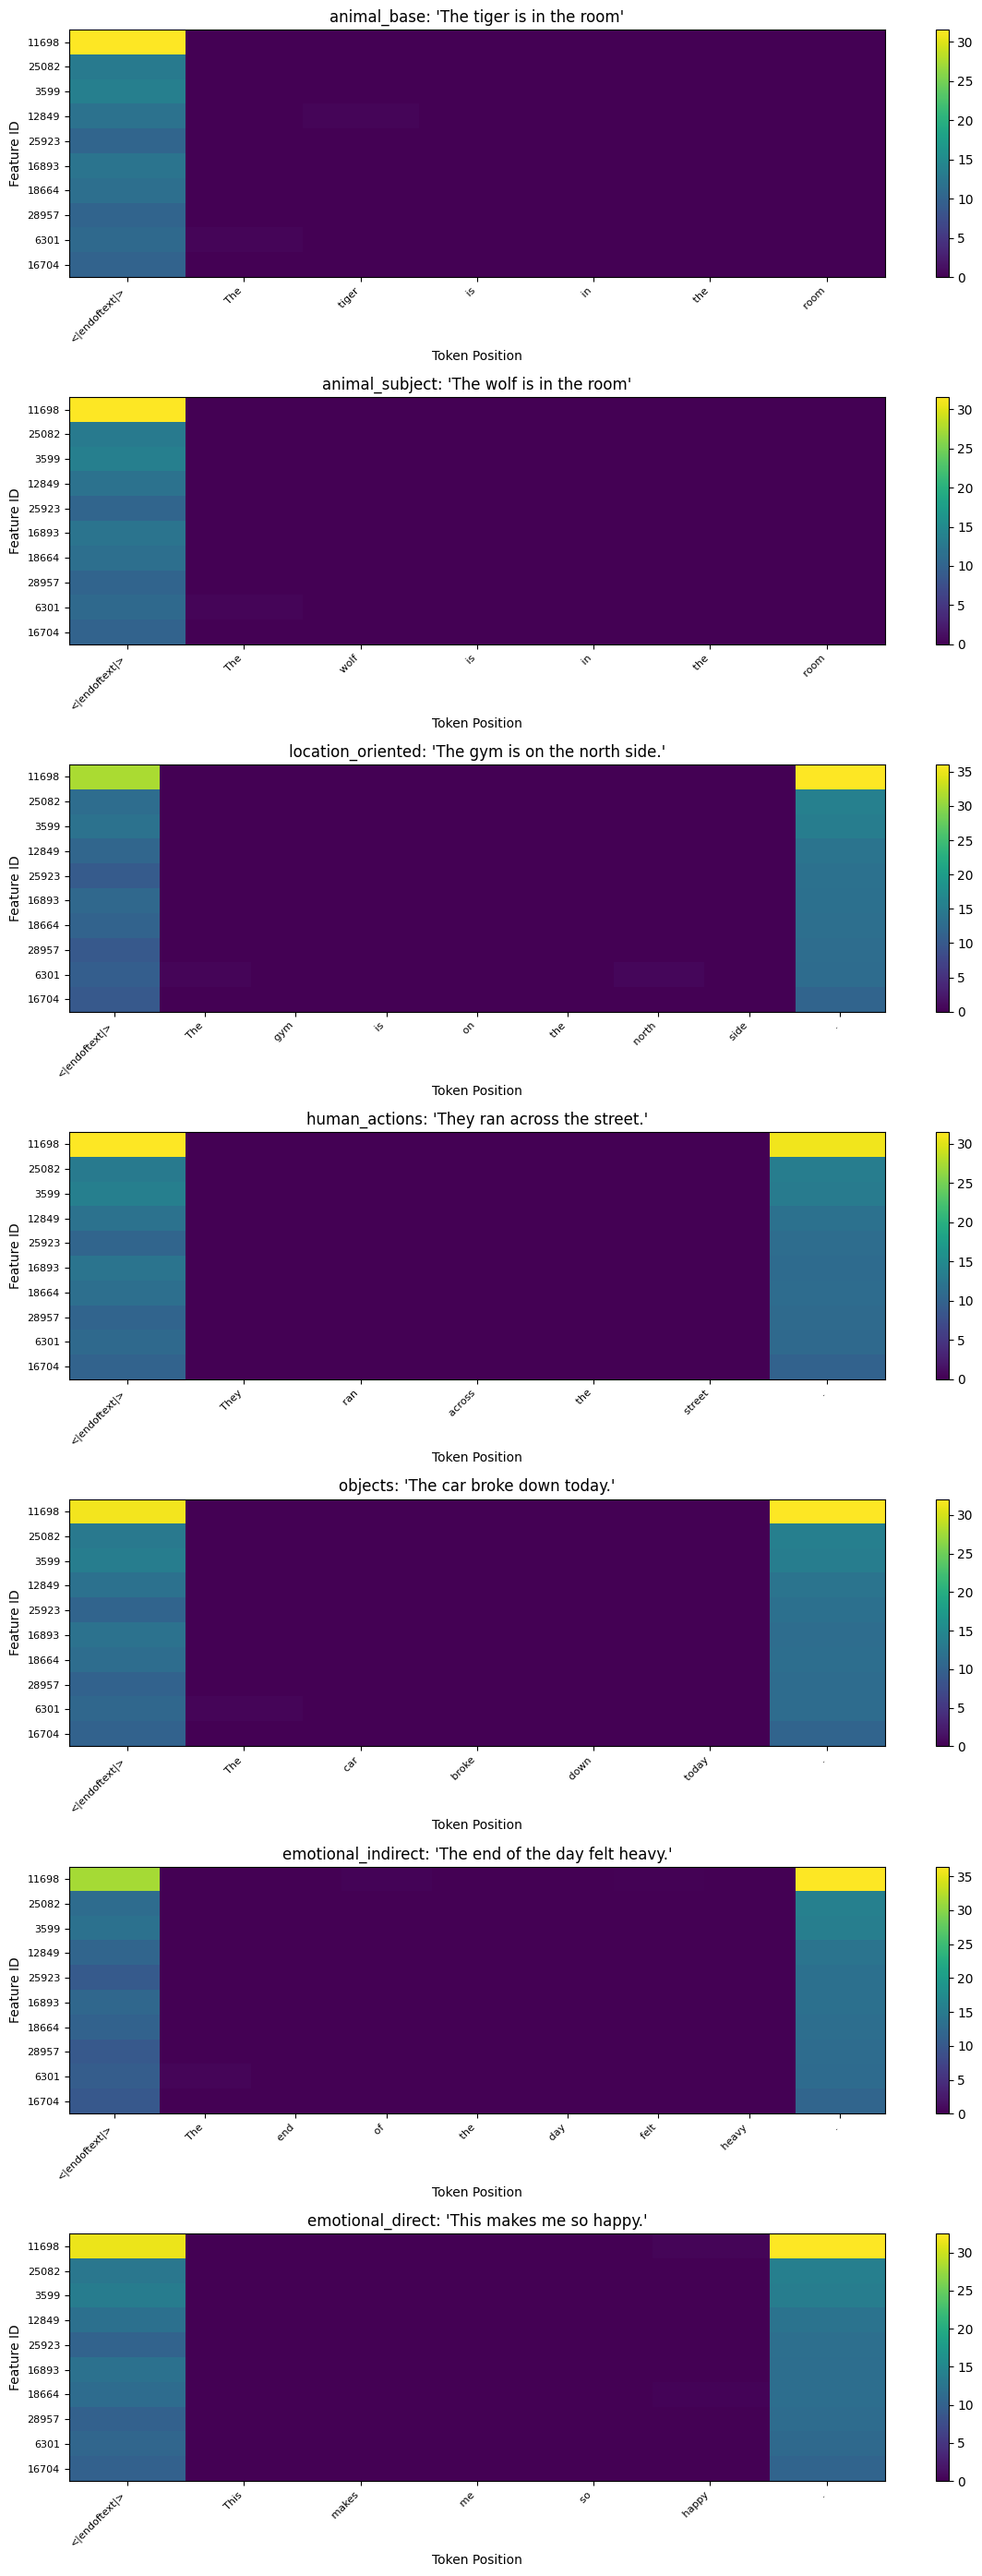

In [10]:
#let's visualize what is happening
import matplotlib.pyplot as plt
import numpy as np

#Show ALL candidate features across ALL test sentences

fig, axes = plt.subplots(len(test_sentences), 1, figsize=(12, 4*len(test_sentences)))
if len(test_sentences) == 1:
  axes = [axes]

candidate_features = [11698, 25082, 3599, 12849, 25923, 16893, 18664, 28957, 6301, 16704]

for idx, (name, data) in enumerate(results.items()):
  #Get activations for this sentence [seq_len, num_features]
  activations = data['activations'].cpu().detach()

  #Extract only candidate features
  candidate_acts = activations[:, candidate_features]

  #Plot heatmap
  im = axes[idx].imshow(candidate_acts.T, aspect='auto', cmap='viridis', interpolation='nearest')
  axes[idx].set_xlabel('Token Position', fontsize=10)
  axes[idx].set_ylabel('Feature ID', fontsize=10)
  axes[idx].set_title(f"{name}: '{test_sentences[name]}'", fontsize=12)

  #Add feature labels on y-axis
  axes[idx].set_yticks(np.arange(len(candidate_features)))
  axes[idx].set_yticklabels(candidate_features, fontsize=8)

  #Add token labels on x-axis
  axes[idx].set_xticks(np.arange(len(data['tokens'])))
  axes[idx].set_xticklabels(data['tokens'], rotation=45, ha='right', fontsize=8)

  plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.savefig('candidate_features_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
from google.colab import files
files.download('candidate_features_heatmap.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#Check: Are there any features activating in the middle and just not the candidate features?

#Picking a sentence to examine
sentence_name = 'animal_base'
activations = results[sentence_name]['activations'].cpu().detach()
tokens = results[sentence_name]['tokens']

print(f"Sentence: {test_sentences[sentence_name]}")
print(f"\nToken-by-token feature activation counts:")
for pos, token in enumerate(tokens):
  num_active = (activations[pos] > 0).sum().item()
  top_features = activations[pos].topk(5)
  print(f" Postion {pos} ('{tokens}): {num_active} features active")
  print(f"   Top 5 features: {top_features.indices.tolist()} with values {[f'{x:.2f}' for x in top_features.values.tolist()]}")

Sentence: The tiger is in the room

Token-by-token feature activation counts:
 Postion 0 ('['<|endoftext|>', 'The', ' tiger', ' is', ' in', ' the', ' room']): 1403 features active
   Top 5 features: [11698, 3599, 25082, 16893, 12849] with values ['31.52', '13.57', '12.89', '12.11', '11.94']
 Postion 1 ('['<|endoftext|>', 'The', ' tiger', ' is', ' in', ' the', ' room']): 68 features active
   Top 5 features: [26906, 779, 21516, 6301, 14580] with values ['0.73', '0.62', '0.54', '0.43', '0.43']
 Postion 2 ('['<|endoftext|>', 'The', ' tiger', ' is', ' in', ' the', ' room']): 159 features active
   Top 5 features: [14190, 21516, 5920, 27099, 31200] with values ['0.98', '0.95', '0.82', '0.62', '0.44']
 Postion 3 ('['<|endoftext|>', 'The', ' tiger', ' is', ' in', ' the', ' room']): 3475 features active
   Top 5 features: [8127, 4807, 29605, 25666, 32658] with values ['1.37', '1.17', '0.99', '0.83', '0.77']
 Postion 4 ('['<|endoftext|>', 'The', ' tiger', ' is', ' in', ' the', ' room']): 1116 f

Between the heatmap and the next code block assessing the top features firing at middle positions, there are several points to address:

1. When we look at the heatmap, we do not see any feature activation for the tokens within the middle of the sentence. Therefore, the next code block is ran to confirm that features are activating in the middle, just not the candidate features (top 10).

2. After running this check, we see that there are many features activating in the middle, depending on the sentence (68 to 4072).

3. From the heatmap, we can say that the candidate features are "special". Feature 11698 is firing particularly strong at the beginning to set the context of the sentence.

4. When looking at token-by-token feature activation of the sentence "The tiger is in the room", feature 32604 appears with a strength of 1.31 for position 6 (corresponding to the word "room").

5. Conclusively, there are two types of features found: high-level structural features (the top 10 candidate features), which fire at the sentence start, and content-specific features (e.g., 32604 at "room"), which fire semantically at important words.
